# Exercises
1、What is the purpose and importance of pooling in CNNs? What is the purpose and
importance of strides in CNNs? (10 points)<br>
Answer: <br>
&emsp; The purpose of pooling is to gradually reduce the spatial size of the representation. By pooling, we can reduce the amount of parameters and computation in the network to control overfitting. <br>
&emsp; The purpose of strides is to reduce the spatial size of feature maps, leading to computational benefits and also reduce the overlap of receptive fields. If the stride is small, more features will be extracted and less information will be discarded, however leading to computation increment and overfitting. If the stride is big, the amount of computation will be reduced, however leading to missing more features.<br>
<br><br>
2、Explain what the convolutional kernels in CNNs represent. (10 points)<br>
Answer:<br>
&emsp; The convolutional kernels in CNNs represent learnable filters that are used to extract useful and important features from images. During the forward pass, we slide each filter across the width and height of the input volume and compute dot products between the entries of the filter and the input at any position. As we slide the filter over the input, we will produce an activation map, or a feature map, that gives the responses of that filter at every spatial position. Intuitively, CNNs will learn filters that activate when they see some type of visual feature such as an edge of some orientation. In other words, through the convolutional kernels, we can filter out redundant information and extract useful features from the input images.<br>
<br><br>
3、How do the features learned in early CNN layers differ from those learned in later layers? Please explain briefly. (10 points)<br>
Answer:<br>
&emsp; Early CNN layers usually learn general and simple features such as edges and textures. In contrast, later layers learn more complex features such as patterns and objects. <br>
&emsp; Receptive fields of neurons in early layers and their overlapping areas are smaller, so filters in early layers can capture more details. As layers go deeper, receptive fields and their overlapping areas increase and image information is compressed. Therefore, more complex features and more abstract information can be learned in later layers.<br>
<br><br>
4、Consider a convolutional layer $l$ with $m^l$ filters, with dimensionality $k^l*k^l*m^{l-1}$ and strides $s^l$, and an input of size $n^{l-1}*n^{l-1}*m^{l-1}$. (10 points)<br>
a. What is the dimensionality of the output of this layer?<br>
Answer:
$$n^l = (n^{l-1} - k^l) / s^l + 1$$
&emsp; So the dimensionality of the output of this layer is $n^l*n^l*m^l$.<br>
<br>
b. Consider the weight tensors which provide the values defining the filters. What is the dimensionality of a single tensor of weight values? How many such tensors will there be? How many weight values will there be overall?<br>
Answer:<br>
&emsp; The dimensionality of a single tensor of weight values is $k^l*k^l*m^{l-1}$.<br>
&emsp; There will be $m^l$ such tensors.<br>
&emsp; There will be $m^l*k^l*k^l*m^{l-1}$ weight values overall.<br>
<br>
c. Consider a fully-connected layer with input and output that have the same
dimensionality as above. How many weights would such a layer have?<br>
Answer:<br>
&emsp; Such a layer have $n^{l-1}*n^{l-1}*m^{l-1}*n^l*n^l*m^l$ weights.


# Software Lab 
## Importing packages and switching to a GPU device

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import torch.nn.functional as F
import numpy as np

USE_GPU = True
dtype = torch.float32   # 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Preparation
Load the MNIST dataset. Then, split the dataset into train/val/test set and print the shape.

In [93]:
# set up a transform to preprocess the data
transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

# training dataset
mnist_train = dset.MNIST('./', train=True, download=True, transform=transform)
mnist_val = dset.MNIST('./', train=True, download=True, transform=transform)

# testing dataset
mnist_test = dset.MNIST('./', train=False, download=True, transform=transform)

# Split the dataset into train/val/test using DataLoader.
NUM_TRAIN = 50000
bs = 64  # batch size

loader_train = DataLoader(mnist_train, batch_size=bs, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(mnist_val, batch_size=bs, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))
loader_test = DataLoader(mnist_test, batch_size=64)

# print the shape of dataset
print('x_train:', (NUM_TRAIN,)+mnist_train[0][0].shape)
print('y_train:', (NUM_TRAIN,))
print('x_val:', (len(mnist_train)-NUM_TRAIN,)+mnist_train[0][0].shape)
print('y_val:', (len(mnist_train)-NUM_TRAIN,))
print('x_test:', (len(mnist_test),)+mnist_test[0][0].shape)
print('y_test:', (len(mnist_test),))

x_train: (50000, 1, 28, 28)
y_train: (50000,)
x_val: (10000, 1, 28, 28)
y_val: (10000,)
x_test: (10000, 1, 28, 28)
y_test: (10000,)


Take a look at the actual images in one batch.

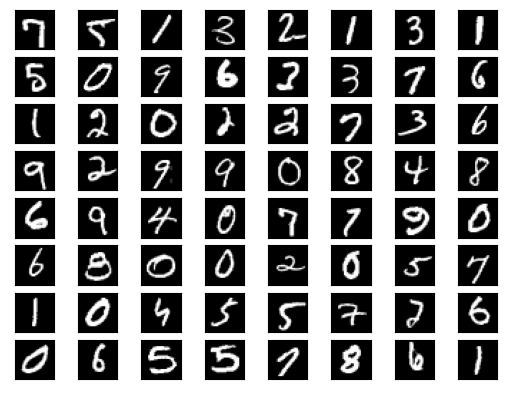

In [94]:
images, _ = next(iter(loader_train))  # one batch of images of shape (64, 1, 28, 28)
images = images.numpy().transpose(0, 2, 3, 1)  # shape: (64, 28, 28, 1)
images = (images * 0.3081 + 0.1307) * 255
for i in range(bs):
    plt.subplot(8, 8, i+1)
    plt.xticks([])  
    plt.yticks([])
    plt.imshow(images[i].astype('uint8'), cmap="gray")
plt.show()

## Model
Write the train and test(check_accuracy) function.

In [95]:
def check_accuracy(loader, model):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        return acc

def train(model, optimizer, epochs=1, verbose = True, print_every = 100):
    """
    Train a model on MNIST using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - verbose: Boolean; if set to false then no output will be printed during training.
    - print_every: (Optional) Integer; training losses will be printed every print_every iterations.
    
    Returns: 
    - loss_history: A list recording the loss of every iteration
    - train_acc_history: A list recording the train accuracy of every iteration
    - val_acc_history: A list recording the validation accuracy of every iteration
    """
    loss_history, train_acc_history,  val_acc_history= [], [], []
    model = model.to(device=device)  # move the model parameters to the device  
    for e in range(epochs):
        # Check train and val accuracy on the first iteration and at the end of each epoch.
        train_acc = check_accuracy(loader_train, model)
        val_acc = check_accuracy(loader_val, model)
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        if verbose:
            print(
                "(Epoch %d / %d) train_acc = %.4f%%, val_acc = %.4f%%" 
                % (e, epochs, 100 * train_acc, 100 * val_acc)
            )

        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            loss.backward()  # backwards pass
            optimizer.step() # update the parameters of the model

            loss_history.append(loss.item())

            if verbose and t % print_every == 0:
                print('(Iteration %d) loss = %.4f' % (t, loss.item()))

    # Check train and val accuracy on the last iteration.
    train_acc = check_accuracy(loader_train, model)
    val_acc = check_accuracy(loader_val, model)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    if verbose:
        print(
            "(Epoch %d / %d) train_acc = %.4f%%, val_acc = %.4f%%" 
            % (e+1, epochs, 100 * train_acc, 100 * val_acc)
        )

    return loss_history, train_acc_history,  val_acc_history

Define the model with the following architecture:
- [conv-relu-pool]x3 -> [affine]x1 -> softmax
1. Convolutional layer (with bias) with 24 5x5 filters, with zero-padding of 2, with stride of 1
2. ReLU
3. pooling layer with window size of 2x2, with stride of 2, without padding
4. Convolutional layer (with bias) with 48 5x5 filters, with zero-padding of 2, with stride of 1
5. ReLU
6. pooling layer with window size of 2x2, with stride of 2, without padding
7. Convolutional layer (with bias) with 64 5x5 filters, with zero-padding of 2, with stride of 1
8. ReLU
9. pooling layer with window size of 2x2, with stride of 2, without padding
10. Fully-connected layer (with bias) to compute scores for 10 classes

In [96]:
#  wrap `flatten` function in a module in order to stack it in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

model = nn.Sequential(   

    # the size of the input is 28x28
    nn.Conv2d(1, 24, 5, 1, 2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),           
    
    # the size of the input is 14x14
    nn.Conv2d(24, 48, 5, 1, 2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),           
    
    # the size of the input is 7x7
    nn.Conv2d(48, 64, 5, 1, 2),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),       
    
    # the size of the input is 3x3
    Flatten(),
    nn.Linear(64 * 3 * 3, 10)
)

optimizer = optim.Adam(model.parameters())


## Training
Now train the model.

In [97]:
loss_history, train_acc_history,  val_acc_history = train(model, optimizer, epochs=10)

(Epoch 0 / 10) train_acc = 10.1360%, val_acc = 10.6400%
(Iteration 0) loss = 2.3025
(Iteration 100) loss = 0.2750
(Iteration 200) loss = 0.0994
(Iteration 300) loss = 0.0579
(Iteration 400) loss = 0.0257
(Iteration 500) loss = 0.0228
(Iteration 600) loss = 0.0547
(Iteration 700) loss = 0.0299
(Epoch 1 / 10) train_acc = 98.8240%, val_acc = 98.6300%
(Iteration 0) loss = 0.0390
(Iteration 100) loss = 0.0761
(Iteration 200) loss = 0.1235
(Iteration 300) loss = 0.0013
(Iteration 400) loss = 0.0077
(Iteration 500) loss = 0.0082
(Iteration 600) loss = 0.0215
(Iteration 700) loss = 0.0248
(Epoch 2 / 10) train_acc = 98.7240%, val_acc = 98.5100%
(Iteration 0) loss = 0.0068
(Iteration 100) loss = 0.0052
(Iteration 200) loss = 0.0209
(Iteration 300) loss = 0.0101
(Iteration 400) loss = 0.0224
(Iteration 500) loss = 0.0064
(Iteration 600) loss = 0.0833
(Iteration 700) loss = 0.0067
(Epoch 3 / 10) train_acc = 99.2280%, val_acc = 98.7800%
(Iteration 0) loss = 0.0190
(Iteration 100) loss = 0.0224
(Ite

## Test
Now test the model on an independent test set.

In [98]:
test_acc = check_accuracy(loader_test, model)
print('test accuracy: %.2f%% ' % (100 * test_acc))

test accuracy: 99.15% 


## Plots
Plot the loss, training accuracy and validation accuracy during optimization to get insight into what's wrong.

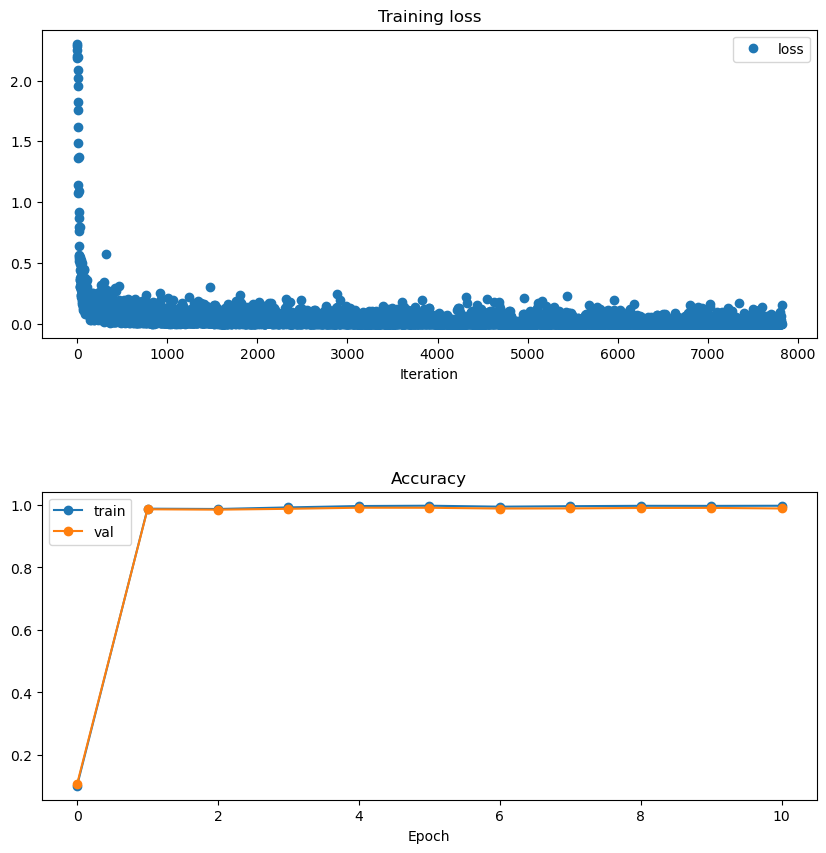

In [99]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
plt.plot(loss_history, 'o', label='loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(train_acc_history, '-o', label='train')
plt.plot(val_acc_history, '-o', label='val')
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.subplots_adjust(hspace=0.5)
plt.show()


Since we can hardly see the difference between the train_accuracy and the val_accuracy on the plot above, now I remove the accuracy before training (Epoch 0) to amplify y axis.

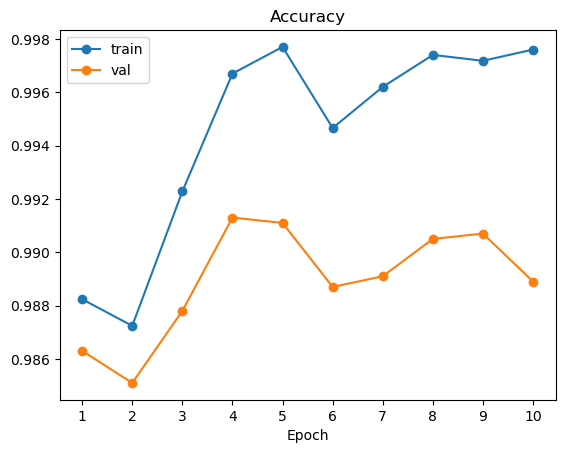

In [100]:
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.plot(list(range(1, len(train_acc_history))), train_acc_history[1:], '-o', label='train')
plt.plot(list(range(1, len(val_acc_history))), val_acc_history[1:], '-o', label='val')
plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

## Summary
1、Performance of the trained model:<br>
&emsp; The trained model performs very well on both the validation set and the test set. During 10 epochs of training, the best accuracy on the training set achieves 99.74% and the best accuracy on the validation set achieve 99.13%. Finally, the accuracy on an independent test set achieve 99.15%.<br>
<br>
2、Architecture of the model: <br>
&emsp; [conv-relu-pool]x3 -> [affine]x1 -> softmax <br>
&emsp; As the suggestion in the lab instruction, I use 3 convolutional layers with 24, 48, 64 filters respectively. Each convolutional layer has 5x5 filters with ReLu activation and 2x2 pooling. To maintain the spatial size of the input when doing conv operation, I use a stride of 1 and zero_padding of 2. And then by using max-pooling with 2x2 receptive fields and with a stride of 2 after activation to downsample the spatial dimensions of the input, both width and height of the input volume can be reduced by half, which means that 75% of the activations are discarded. After 3 convolutional layers, the size of an input that is originally 1x28x28 becomes 64x3x3. Finally, I use a fully connected layer to map features to output.<br>
<br>
3、Plots of the loss, training accuracy and validation accuracy:<br>
&emsp; Looking at the visualization of the loss above, we see that the loss decreases rapidly in the first few hundreds of iterations. Then it reaches a plateau and just fluctuates around certain value, which means that the model stucks at a local minimum (maybe the global minimum). Maybe we can reduce the learning rate to approach the local minimum further to reduce the loss, but we don't need to do that because the loss is already very small and smaller learning rate leads to slower training. So the learning rate (lr=1e-3) is perfect.<br>
&emsp; Looking at the visualization of the training accuracy and validation accuracy above, we see that there is no gap between them. Both increase sharply from 10% to 98% after just one epoch and then reach a plateau. After amplifying y axis, we can clearly see a drop between them. What's more, general variation trend of the validation accuracy is the same as the training accuracy. However, the gap becomes larger, and at the end of training, the training accuracy increases while the validation accuracy decreases, which probably suggests that the model is a little overfitting. 